### Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split ## 訓練、測試切割
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
import xgboost as xgb

### Data Preprocessing

In [2]:
house_data = pd.read_csv("HousingData.csv", header= None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
house_data = house_data.drop(0,axis=0)
#刪除重複的值
print("原始比數：",house_data.shape)
house_data.drop_duplicates(inplace=True)
house_data = house_data.sort_index(axis=0)
print("刪除重複的值後：",house_data.shape)

# 判斷是否還有空值
house_data.isnull().sum(axis=0)

原始比數： (506, 14)
刪除重複的值後： (506, 14)


CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [3]:
#將把'LSTAT'中無法轉換為數字的值設為 NaN
house_data['CRIM'] = pd.to_numeric(house_data['CRIM'], errors='coerce')
house_data['ZN'] = pd.to_numeric(house_data['ZN'], errors='coerce')
house_data['INDUS'] = pd.to_numeric(house_data['INDUS'], errors='coerce')
house_data['CHAS'] = pd.to_numeric(house_data['CHAS'], errors='coerce')
house_data['AGE'] = pd.to_numeric(house_data['AGE'], errors='coerce')
house_data['LSTAT'] = pd.to_numeric(house_data['LSTAT'], errors='coerce')

#刪除問號的值(取平均數)
house_data['CRIM'].fillna(house_data['CRIM'].mean(), inplace=True)
house_data['ZN'].fillna(house_data['ZN'].mean(), inplace=True)
house_data['INDUS'].fillna(house_data['INDUS'].mean(), inplace=True)
house_data['CHAS'].fillna(house_data['CHAS'].mean(), inplace=True)
house_data['AGE'].fillna(house_data['AGE'].mean(), inplace=True)
house_data['LSTAT'].fillna(house_data['LSTAT'].mean(), inplace=True)

In [4]:
## 補值後空值檢查
house_data.isnull().sum(axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [5]:
## 數值屬性做Normalization(z-score)
numerical_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
# house_data['NOX'] = pd.to_numeric(house_data['NOX'], errors='coerce')
# house_data['RM'] = pd.to_numeric(house_data['RM'], errors='coerce')
# house_data['DIS'] = pd.to_numeric(house_data['DIS'], errors='coerce')
# numerical_columns = ['CRIM', 'ZN', 'INDUS', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scaler = preprocessing.StandardScaler()
house_data[numerical_columns] = scaler.fit_transform(house_data[numerical_columns])
house_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,-0.422328,0.296443,-1.311010,-0.279851,-0.144217,0.413672,-1.210593e-01,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.104146,24
2,-0.419870,-0.489639,-0.599771,-0.279851,-0.740262,0.194274,3.787156e-01,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.510353,21.6
3,-0.419872,-0.489639,-0.599771,-0.279851,-0.740262,1.282714,-2.706270e-01,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.239748,34.7
4,-0.419277,-0.489639,-1.330435,-0.279851,-0.835284,1.016303,-8.287698e-01,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.395333,33.4
5,-0.414981,-0.489639,-1.330435,-0.279851,-0.835284,1.228577,-5.223385e-01,1.077737,-0.752922,-1.106115,0.113032,0.441052,0.000000,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,-0.415733,-0.489639,0.126411,-0.279851,0.158124,0.439316,2.121240e-02,-0.625796,-0.982843,-0.803212,1.176466,0.387217,0.000000,22.4
503,-0.417766,-0.489639,0.126411,-0.279851,0.158124,-0.234548,2.984598e-01,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.518917,20.6
504,-0.415952,-0.489639,0.126411,-0.279851,0.158124,0.984960,8.201227e-01,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-1.009938,23.9
505,-0.410232,-0.489639,0.126411,-0.279851,0.158124,0.725672,7.581068e-01,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.890038,22


### Dataset Splitting

In [26]:
house_process=[]
for i in house_data["MEDV"].ravel():
    house_process.append(float(i))
house_data["MEDV"]=house_process
#切分feature attributes & target attributes
X = house_data.drop("MEDV",axis=1)
y = house_data["MEDV"]

## 未使用k-fold validation
## 切分訓練集與測試集 7:3(215) / 8:2(6984)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=216)

## 建立模型
# xgbrModel=xgb.XGBRegressor(booster='gbtree',max_depth=5,eta=0.2,gamma=10)
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(X_train,y_train)
print(f'訓練績效：{xgbrModel.score(X_train,y_train)}')
pred_train=xgbrModel.predict(X_train)
print(f'訓練績效(RMSE)：{np.sqrt(mean_squared_error(y_train,pred_train))}')
print(f'訓練績效(MAPE)：{mean_absolute_percentage_error(y_train,pred_train)}')
print(f'訓練績效(R_squared)：{r2_score(y_train,pred_train)}')
print('================================')

### Evaluation
pred=xgbrModel.predict(X_test)
print(f'測試績效(RMSE)：{np.sqrt(mean_squared_error(y_test,pred))}')
print(f'測試績效(MAPE)：{mean_absolute_percentage_error(y_test,pred)}')
print(f'測試績效(R_squared)：{r2_score(y_test,pred)}')

訓練績效：0.9999988633944092
訓練績效(RMSE)：0.009483469063618926
訓練績效(MAPE)：0.0003471026451591211
訓練績效(R_squared)：0.9999988633944092
測試績效(RMSE)：2.4850061842744946
測試績效(MAPE)：0.08782690884718915
測試績效(R_squared)：0.9354737754498822


#### * 使用k-fold validation

In [24]:
## 使用k-fold validation
kf = KFold(n_splits=5, shuffle=True, random_state=400)
scores = cross_val_score(xgbrModel,X,y,cv=kf,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=0)
print(f'每次K-fold(5)的績效:{abs(scores),2}')
print(f'平均K-fold(5)的績效:{abs(scores).mean()}')

每次K-fold(5)的績效:(array([2.90379609, 3.61505422, 2.27750403, 2.18628764, 3.88215995]), 2)
平均K-fold(5)的績效:2.972960386092517


In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
scores = cross_val_score(xgbrModel,X,y,cv=kf,scoring='neg_mean_absolute_percentage_error',n_jobs=-1,verbose=0)
print(f'每次K-fold(5)的績效:{abs(scores),2}')
print(f'平均K-fold(5)的績效:{abs(scores).mean()}')

每次K-fold(5)的績效:(array([0.09933801, 0.14645777, 0.08814155, 0.08820506, 0.12666866]), 2)
平均K-fold(5)的績效:0.10976221117595282


In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
scores = cross_val_score(xgbrModel,X,y,cv=kf,scoring='r2',n_jobs=-1,verbose=0)
print(f'每次K-fold(5)的績效:{abs(scores),2}')
print(f'平均K-fold(5)的績效:{abs(scores).mean()}')

每次K-fold(5)的績效:(array([0.86901427, 0.83567918, 0.92128145, 0.95489745, 0.84998562]), 2)
平均K-fold(5)的績效:0.8861715938173473


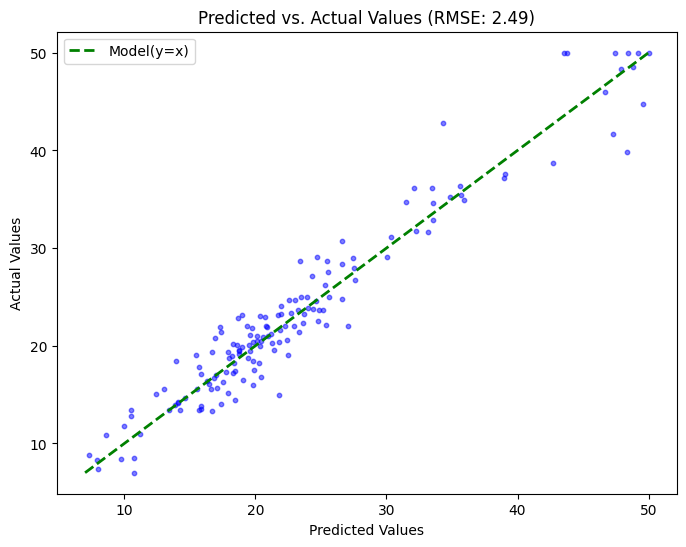

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(pred,y_test.ravel(),c='b',s=10,alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green', linewidth=2, label='Model(y=x)')
plt.title(f'Predicted vs. Actual Values (RMSE: {np.sqrt(mean_squared_error(y_test,pred)):.2f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

#### Feature Importance

In [32]:
xfeatures=list(X_train.columns[:])  
importances = list(xgbrModel.feature_importances_)
df_importance = pd.DataFrame({'feature':xfeatures,'feature_importance':importances})
df_importance = df_importance.sort_values(by=['feature_importance'],ascending=False).reset_index(drop=True)
print("每個特徵值的重要性：")
print(df_importance.loc[df_importance['feature_importance']!=0])

每個特徵值的重要性：
    feature  feature_importance
0     LSTAT            0.450934
1        RM            0.181637
2       DIS            0.143727
3   PTRATIO            0.072957
4       TAX            0.041516
5       NOX            0.037943
6       RAD            0.026737
7      CRIM            0.015195
8       AGE            0.008440
9     INDUS            0.008316
10     CHAS            0.005464
11        B            0.005158
12       ZN            0.001977


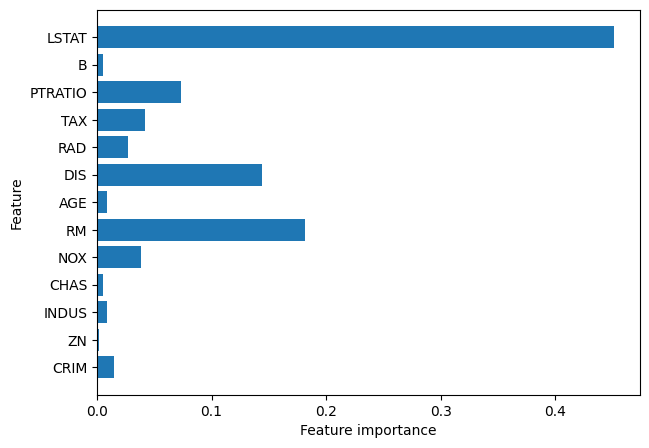

In [33]:
#以圖表事每個特徵變數的重要程度(0最小，1最大)
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(7,5))
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(xgbrModel)

#### Delete feature attributes one by one

In [36]:
def split_dataset(fname,df,y):
    if(fname!=0):
        df = df.drop(fname,axis=1)

    ## 切分訓練集與測試集 7:3(215) / 8:2(6984)
    X_train,X_test,y_train,y_test=train_test_split(df,y,test_size=0.3, random_state=216)

    ## 建立模型
    xgbrModel=xgb.XGBRegressor()
    xgbrModel.fit(X_train,y_train)
    # pred=xgbrModel.predict(X_train)
    # print(f'訓練績效(RMSE)：{np.sqrt(mean_squared_error(y_train,pred))}')
    # scores = cross_val_score(xgbrModel,X_train,y_train,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=0)
    # print(f'每次K-fold(5)的績效:{abs(scores)}')
    # print(f'平均K-fold(5)的績效:{round(abs(scores).mean(),3)}')
    
    print('======================================================\n\t\tPerformance Test\n======================================================')
    ## 預測
    y_pred=xgbrModel.predict(X_test)
    #calculate rmse
    error_rmse = np.sqrt(mean_squared_error(y_test,y_pred)) 
    print('RMSE:', round(error_rmse,3))
    #calculate mape
    error_mape = mean_absolute_percentage_error(y_test,y_pred) 
    print(f'MAPE:{round((error_mape),2)}%')
    #calculate r squared
    error_r2 = r2_score(y_test,y_pred) 
    print('r_squared_value:', round(error_r2,3))

    print('======================================================\n\t\tCorrelation\n======================================================')
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred,y_test.ravel(),c='b',s=10,alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green', linewidth=2, label='Model(y=x)')
    plt.title(f'Predicted vs. Actual Values (RMSE: {error_rmse:.2f})')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.legend()
    plt.show()
    print(df)
    print('---------------------------------------------------------------------------------\n')

    return df

每個特徵值的重要性：
    feature  feature_importance
0     LSTAT            0.450934
1        RM            0.181637
2       DIS            0.143727
3   PTRATIO            0.072957
4       TAX            0.041516
5       NOX            0.037943
6       RAD            0.026737
7      CRIM            0.015195
8       AGE            0.008440
9     INDUS            0.008316
10     CHAS            0.005464
11        B            0.005158
12       ZN            0.001977
刪除欄位：ZN
		Performance Test
RMSE: 2.506
MAPE:0.09%
r_squared_value: 0.934
		Correlation


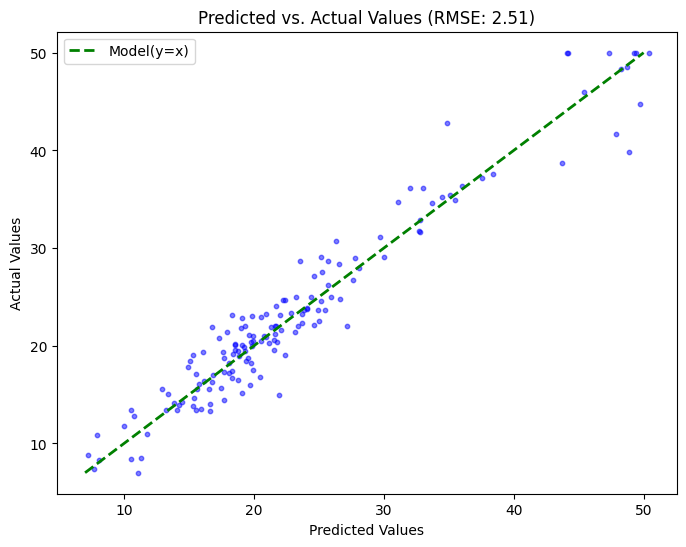

         CRIM     INDUS      CHAS       NOX        RM           AGE       DIS  \
1   -0.422328 -1.311010 -0.279851 -0.144217  0.413672 -1.210593e-01  0.140214   
2   -0.419870 -0.599771 -0.279851 -0.740262  0.194274  3.787156e-01  0.557160   
3   -0.419872 -0.599771 -0.279851 -0.740262  1.282714 -2.706270e-01  0.557160   
4   -0.419277 -1.330435 -0.279851 -0.835284  1.016303 -8.287698e-01  1.077737   
5   -0.414981 -1.330435 -0.279851 -0.835284  1.228577 -5.223385e-01  1.077737   
..        ...       ...       ...       ...       ...           ...       ...   
502 -0.415733  0.126411 -0.279851  0.158124  0.439316  2.121240e-02 -0.625796   
503 -0.417766  0.126411 -0.279851  0.158124 -0.234548  2.984598e-01 -0.716639   
504 -0.415952  0.126411 -0.279851  0.158124  0.984960  8.201227e-01 -0.773684   
505 -0.410232  0.126411 -0.279851  0.158124  0.725672  7.581068e-01 -0.668437   
506 -0.417515  0.126411 -0.279851  0.158124 -0.362767  5.184109e-16 -0.613246   

          RAD       TAX   P

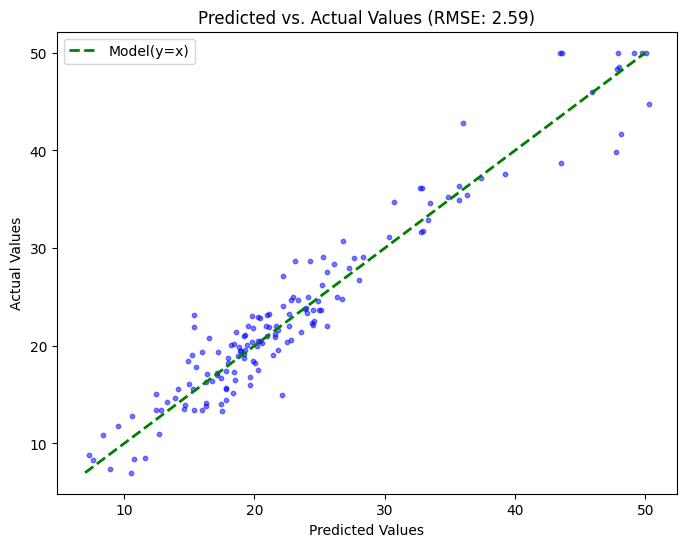

         CRIM     INDUS      CHAS       NOX        RM           AGE       DIS  \
1   -0.422328 -1.311010 -0.279851 -0.144217  0.413672 -1.210593e-01  0.140214   
2   -0.419870 -0.599771 -0.279851 -0.740262  0.194274  3.787156e-01  0.557160   
3   -0.419872 -0.599771 -0.279851 -0.740262  1.282714 -2.706270e-01  0.557160   
4   -0.419277 -1.330435 -0.279851 -0.835284  1.016303 -8.287698e-01  1.077737   
5   -0.414981 -1.330435 -0.279851 -0.835284  1.228577 -5.223385e-01  1.077737   
..        ...       ...       ...       ...       ...           ...       ...   
502 -0.415733  0.126411 -0.279851  0.158124  0.439316  2.121240e-02 -0.625796   
503 -0.417766  0.126411 -0.279851  0.158124 -0.234548  2.984598e-01 -0.716639   
504 -0.415952  0.126411 -0.279851  0.158124  0.984960  8.201227e-01 -0.773684   
505 -0.410232  0.126411 -0.279851  0.158124  0.725672  7.581068e-01 -0.668437   
506 -0.417515  0.126411 -0.279851  0.158124 -0.362767  5.184109e-16 -0.613246   

          RAD       TAX   P

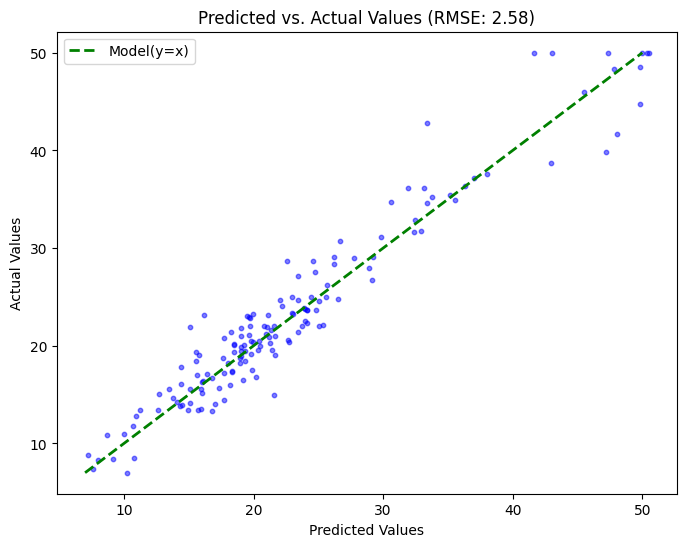

         CRIM     INDUS       NOX        RM           AGE       DIS       RAD  \
1   -0.422328 -1.311010 -0.144217  0.413672 -1.210593e-01  0.140214 -0.982843   
2   -0.419870 -0.599771 -0.740262  0.194274  3.787156e-01  0.557160 -0.867883   
3   -0.419872 -0.599771 -0.740262  1.282714 -2.706270e-01  0.557160 -0.867883   
4   -0.419277 -1.330435 -0.835284  1.016303 -8.287698e-01  1.077737 -0.752922   
5   -0.414981 -1.330435 -0.835284  1.228577 -5.223385e-01  1.077737 -0.752922   
..        ...       ...       ...       ...           ...       ...       ...   
502 -0.415733  0.126411  0.158124  0.439316  2.121240e-02 -0.625796 -0.982843   
503 -0.417766  0.126411  0.158124 -0.234548  2.984598e-01 -0.716639 -0.982843   
504 -0.415952  0.126411  0.158124  0.984960  8.201227e-01 -0.773684 -0.982843   
505 -0.410232  0.126411  0.158124  0.725672  7.581068e-01 -0.668437 -0.982843   
506 -0.417515  0.126411  0.158124 -0.362767  5.184109e-16 -0.613246 -0.982843   

          TAX   PTRATIO    

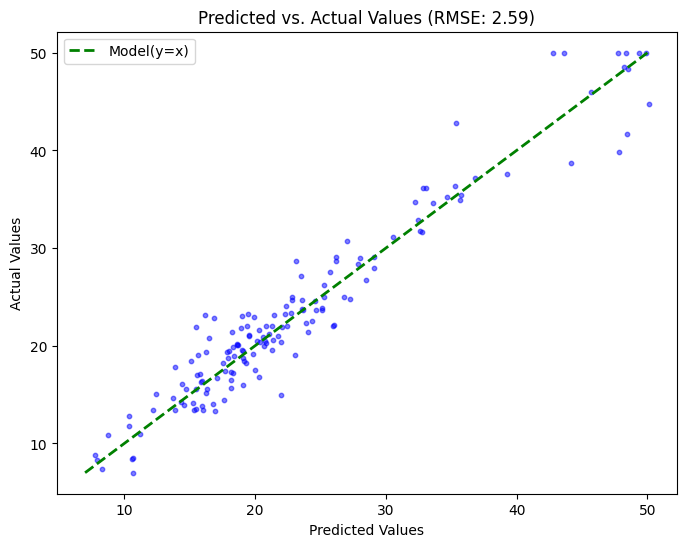

         CRIM       NOX        RM           AGE       DIS       RAD       TAX  \
1   -0.422328 -0.144217  0.413672 -1.210593e-01  0.140214 -0.982843 -0.666608   
2   -0.419870 -0.740262  0.194274  3.787156e-01  0.557160 -0.867883 -0.987329   
3   -0.419872 -0.740262  1.282714 -2.706270e-01  0.557160 -0.867883 -0.987329   
4   -0.419277 -0.835284  1.016303 -8.287698e-01  1.077737 -0.752922 -1.106115   
5   -0.414981 -0.835284  1.228577 -5.223385e-01  1.077737 -0.752922 -1.106115   
..        ...       ...       ...           ...       ...       ...       ...   
502 -0.415733  0.158124  0.439316  2.121240e-02 -0.625796 -0.982843 -0.803212   
503 -0.417766  0.158124 -0.234548  2.984598e-01 -0.716639 -0.982843 -0.803212   
504 -0.415952  0.158124  0.984960  8.201227e-01 -0.773684 -0.982843 -0.803212   
505 -0.410232  0.158124  0.725672  7.581068e-01 -0.668437 -0.982843 -0.803212   
506 -0.417515  0.158124 -0.362767  5.184109e-16 -0.613246 -0.982843 -0.803212   

      PTRATIO     LSTAT  
1

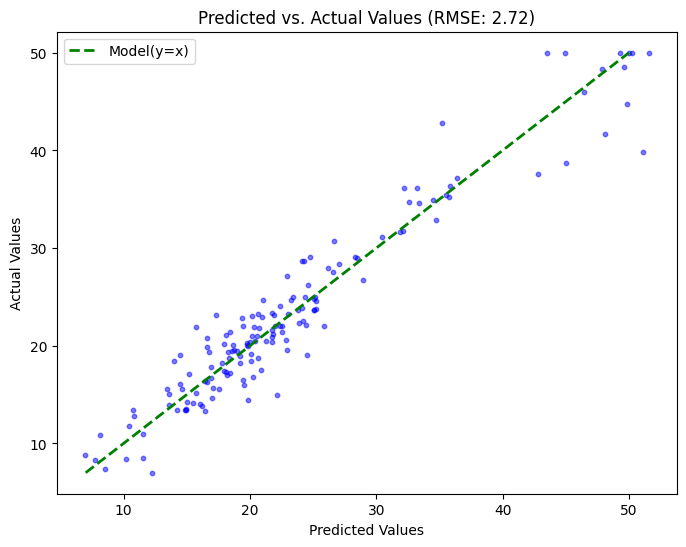

         CRIM       NOX        RM       DIS       RAD       TAX   PTRATIO  \
1   -0.422328 -0.144217  0.413672  0.140214 -0.982843 -0.666608 -1.459000   
2   -0.419870 -0.740262  0.194274  0.557160 -0.867883 -0.987329 -0.303094   
3   -0.419872 -0.740262  1.282714  0.557160 -0.867883 -0.987329 -0.303094   
4   -0.419277 -0.835284  1.016303  1.077737 -0.752922 -1.106115  0.113032   
5   -0.414981 -0.835284  1.228577  1.077737 -0.752922 -1.106115  0.113032   
..        ...       ...       ...       ...       ...       ...       ...   
502 -0.415733  0.158124  0.439316 -0.625796 -0.982843 -0.803212  1.176466   
503 -0.417766  0.158124 -0.234548 -0.716639 -0.982843 -0.803212  1.176466   
504 -0.415952  0.158124  0.984960 -0.773684 -0.982843 -0.803212  1.176466   
505 -0.410232  0.158124  0.725672 -0.668437 -0.982843 -0.803212  1.176466   
506 -0.417515  0.158124 -0.362767 -0.613246 -0.982843 -0.803212  1.176466   

        LSTAT  
1   -1.104146  
2   -0.510353  
3   -1.239748  
4   -1.3953

In [37]:
## 找特徵重要性
xfeatures=list(X_train.columns[:])  
importances = list(xgbrModel.feature_importances_)
df_importance = pd.DataFrame({'feature':xfeatures,'feature_importance':importances})
df_importance = df_importance.sort_values(by=['feature_importance'],ascending=False).reset_index(drop=True)
print("每個特徵值的重要性：")
print(df_importance.loc[df_importance['feature_importance']!=0])

#切分feature attributes & target attributes
X = house_data.drop("MEDV",axis=1)
y = house_data["MEDV"]
for k in range(5):
    ##找最不重要的特徵
    feature = df_importance.iloc[np.argmin(df_importance['feature_importance'])]['feature']
    print(f'刪除欄位：{feature}')
    X = split_dataset(feature,X,y)
    # 删除包含特定值的行，並就地修改原始 DataFrame
    df_importance.drop(df_importance[df_importance['feature'] == feature].index, inplace=True)

----------------